In [ ]:
# 東京23区で一番緑が多い区はどちら

特に東京に行ったこともないのですが、東京で一番緑が多いのはどこかがふと気になったのです。将来移住するときに参考になるかもしれないので調べます。

## やりかた

1. 行政区域データを集める
2. 土地利用データを集める
3. 各行政区域について土地利用ごとの面積を算出
4. 各行政区域について、自然っぽい土地利用の割合を算出

当然このようにすればできます。文字にすると簡単そうです。

## データ収集

行政区域データは[国土数値情報ダウンロードサイト](http://nlftp.mlit.go.jp/ksj/)から取得します。平成29年版の東京都のジオメトリデータで、[ESRI Shapefile形式](https://ja.wikipedia.org/wiki/%E3%82%B7%E3%82%A7%E3%83%BC%E3%83%97%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB)をダウンロードします。

土地利用データは[ALOSの高解像度土地利用土地被覆図](http://www.eorc.jaxa.jp/ALOS/lulc/jlulc_jpn.htm)の10mメッシュの[geotiff](https://ja.wikipedia.org/wiki/GeoTIFF)をダウンロードし、必要そうなところだけ展開します。

収集したデータは以下になります。geotiffだけで3GBくらいあります。

```bash
$ tree .
├── geotiff
│   ├── LC_N20E136.tif
│   ├── LC_N24E141.tif
│   ├── LC_N24E153.tif
│   ├── LC_N25E141.tif
│   ├── LC_N26E142.tif
│   ├── LC_N27E140.tif
│   ├── LC_N27E142.tif
│   ├── LC_N30E140.tif
│   ├── LC_N32E139.tif
│   ├── LC_N33E136.tif
│   ├── LC_N33E139.tif
│   ├── LC_N34E136.tif
│   ├── LC_N34E137.tif
│   ├── LC_N34E138.tif
│   ├── LC_N34E139.tif
│   ├── LC_N35E136.tif
│   ├── LC_N35E137.tif
│   ├── LC_N35E138.tif
│   ├── LC_N35E139.tif
│   ├── LC_N35E140.tif
│   └── ver1609_LC_GeoTiff.tgz
└── shapefiles
     ├── KS-META-N03-17_13_170101.xml
     ├── N03-17_13_170101.dbf
     ├── N03-17_13_170101.prj
     ├── N03-17_13_170101.shp
     ├── N03-17_13_170101.shx
     └── N03-17_13_170101.xml
```

## DockerでPostGISサーバを立てる

行政区域の土地利用ごとの面積を計算するには、行政区域のジオメトリを土地利用ごとに切り出したジオメトリを用意する必要があります。
ジオメトリ演算といえばPostGISを使うもののようです。環境構築は面倒くさそうなので、dockerを使います。

以下のようなDockerfileを用意します。

```Dockerfile
FROM mdillon/postgis:latest
RUN rm -rf /docker-entrypoint-initdb.d/postgis.sh
EXPOSE 5432
```

/docker-entrypoint-initdb.d/にはコンテナ起動直後に実行するポスグレDB初期化スクリプトが配置されます。postgis.shはmdillon/postgisが用意したPostGIS初期設定スクリプトなのですが、不要なextensionとかもインストールするので削除します。
ちなみに/docker-entrypoint-initdb.d/内のスクリプトは名前順に実行されるっぽいので、適当な名前でオレオレスクリプトを配置すると実行順序が狂って死んだりするので注意が必要です。

```
$ docker build --no-cache -t postgis_calcgreen .
$ docker run \
  -e POSTGRES_DB=postgres \
  -e POSTGRES_USER=postgres \
  -e POSTGRES_PASSWORD=postgres \
  -v "$PWD":/usr/src/myapp \
  -w /usr/src/myapp \
  --name postgis_calcgreen \
  -p 5432:5432 \
  postgis_calcgreen
```

イメージつくってコンテナ起動します。パスワード等はテキトーです。/docker-entrypoint-initdb.d/のスクリプトがコンテナ起動直後に走るので、それを確認するために"-d"は付けないのが無難です。

動作確認します。psqlコマンド使います。postgresqlでは"\l"でデータベース一覧が取得できます。

```
$ export PGHOST=localhost
$ export PGDATABASE=postgres
$ export PGUSER=postgres
$ export PGPASSWORD=postgres
$ psql -c "\l"
                                 List of databases
   Name    |  Owner   | Encoding |  Collate   |   Ctype    |   Access privileges   
-----------+----------+----------+------------+------------+-----------------------
 postgres  | postgres | UTF8     | en_US.utf8 | en_US.utf8 | 
 template0 | postgres | UTF8     | en_US.utf8 | en_US.utf8 | =c/postgres          +
           |          |          |            |            | postgres=CTc/postgres
 template1 | postgres | UTF8     | en_US.utf8 | en_US.utf8 | =c/postgres          +
           |          |          |            |            | postgres=CTc/postgres
(3 rows)
```

PostGISサーバが立ち上がりました。

続いてpostgis extensionを追加します。

```
$ psql -c "create extension if not exists postgis;"
CREATE EXTENSION
$ psql -c "\dx;"
                                     List of installed extensions
  Name   | Version |   Schema   |                             Description                             
---------+---------+------------+---------------------------------------------------------------------
 plpgsql | 1.0     | pg_catalog | PL/pgSQL procedural language
 postgis | 2.3.2   | public     | PostGIS geometry, geography, and raster spatial types and functions
(2 rows)

```

できました。

行政区域シェープファイルはdockerコンテナにインストールしたshp2pgsqlでsqlに変換し、tmpテーブルとしてインポートします。-iはInt4指定、-Iはgistインデックス作成、-Wは文字コード指定です。sqlに変換したら直接psqlに流して実行します。

tmpテーブルのカラムを調整し、全レコードを市区町村でgroup byしてST_Unionしてjapan_ksテーブルにインポートします。tmpテーブルはお役御免とdropします。

```
$ docker exec -i $PGCONTAINER bash -c \
'shp2pgsql -s 4326 -D -i -I -W cp932 shapefiles/*.shp tmp' | psql >/dev/null
$ cat << EOS | psql
delete from tmp where n03_007 is NULL;

alter table tmp rename n03_001 to prefecture_name;
alter table tmp rename n03_007 to city_code;

alter table tmp add prefecture_code varchar(2);
update tmp set prefecture_code = substring(city_code,1,2);

alter table tmp add city_name varchar(60);
update tmp set city_name = coalesce(n03_003, '') || coalesce(n03_004, '');

create table japan_ks as
  select
    cast(prefecture_code as integer) as prefecture_code
    , prefecture_name
    , cast(city_code as integer) as city_code
    , city_name
    , sum(ST_Area(geography(geom))) as area
    , ST_Union(geom) as geom
  from tmp
  group by
    prefecture_code
    , prefecture_name
    , city_code
    , city_name
    ;
drop table tmp;
create index on japan_ks using gist (geom);
analyze japan_ks;
EOS
```

次にalos土地利用データをインポートします。raster2pgsqlコマンドを使います。-Iはインデックス作成、-Cは「SRIDやピクセルサイズ等のラスタ制約を適用して、raster_columnsビューで適切な登録ができるようにします。 」らしいです。-Nはヌル値指定、-tは1レコード当たりのタイルサイズです。タイルサイズが大きいとジオメトリ演算で時間がかかりそうですが、小さいとインポートに時間がかかります。

```sh
$ ALOS_GEOTIF=./geotiff/LC*.tif
$ docker exec -i $PGCONTAINER bash <<EOF | psql > /dev/null
raster2pgsql -I -C -s 4326 -N 0 -t 100x100 \
$ALOS_GEOTIF \
alos_rast
EOF
```

alos区分テーブルを下のsqlで作成します。

```sql
create table alos_code_name (
code integer primary key,
name varchar(40)
);
insert into alos_code_name (code, name) values
    (0,   '未分類'),
    (1,   '水域'),
    (2,   '都市'),
    (3,   '水田'),
    (4,   '畑地'),
    (5,   '草地'),
    (6,   '落葉広葉樹'),
    (7,   '落葉針葉樹'),
    (8,   '常緑広葉樹'),
    (9,   '常緑針葉樹'),
    (10,  '裸地'),
    (11,  '雪氷'),
    (253, 'その他'),
    (255, 'データなし')
;
```

alos_rastに格納したラスタデータをジオメトリに変換してalos_geoに格納します。行政区域ジオメトリと交差する土地利用ラスタのみ変換します。

```sql
create table alos_geo as
  select
    alos_geo.rid as rid
    , (alos_geo.geomval).val as code
    , (alos_geo.geomval).geom as geom
  from
    (select
      alos_rast.rid as rid
      , ST_DumpAsPolygons(alos_rast.rast) as geomval
    from
      (select ST_Union(geom) as geom from japan_ks) as whole_japan
      , alos_rast
    where
      ST_Intersects(whole_japan.geom, alos_rast.rast)
    ) as alos_geo
  ;
create index on alos_geo using gist (geom);
analyze alos_geo;
```

japan_ksとalos_geoのそれぞれのジオメトリのintersection(交差ジオメトリ)をjapan_alosテーブルに格納します。今回はalosのラスタをジオメトリに変換して(alos_geoテーブル)ST_Intersectionの引数に与えていますが、ST_Intersectionはラスタを直接引数にとることもできます(その場合は裏でラスタデータのST_DumpAsPolygonsが走る)。

```sql
create table japan_alos as
select
  japan_ks.city_code as city_code
  , japan_ks.city_name as city_name
  , alos_geo.code as alos_code
  , ST_Intersection(japan_ks.geom, alos_geo.geom) as geom
from
  japan_ks
  , alos_geo
where
  ST_Intersects(japan_ks.geom, alos_geo.geom)
;
```

準備できました。可視化したり緑の多いところを調べたりします。Pythonを使います。GISの可視化といえばgeopandasなのだそうです。

In [1]:
%matplotlib inline
# ref. https://geohackweek.github.io/vector/06-geopandas-advanced/
import psycopg2

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('bmh')

import pandas as pd
import geopandas as gpd

適当にmatplotlibの設定をします。

In [2]:
mpl.rc('font', family='Osaka') # Macだとこれで日本語が文字化けしない
mpl.rc('legend', loc="lower left", fontsize='large')
# geopandas v0.3.0のlegend.locはbestでハードコードされているのでrcで指定しても無意味

PostGISサーバのアクセス情報です。

In [3]:
db_conn_dict = {
    "host":"localhost",
    "port":5432,
    "dbname":"postgres",
    "user":"postgres",
    "password":"postgres"
}

試しに行政区域ジオメトリを可視化します。

In [4]:
with psycopg2.connect(**db_conn_dict) as conn:
    japan_ks = gpd.read_postgis(
        "SELECT * FROM japan_ks", 
        conn,
        geom_col='geom',
        crs={'init': u'epsg:4326'}
    )

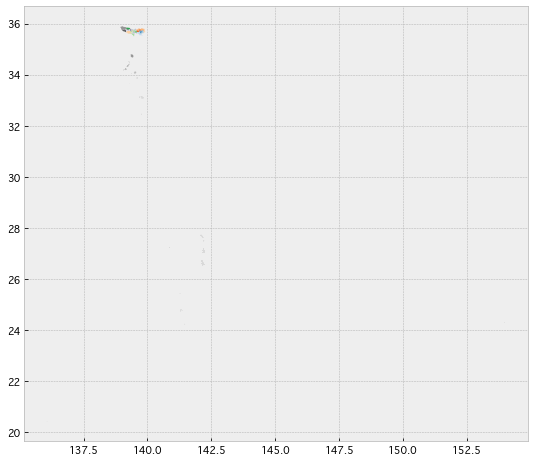

In [5]:
japan_ks.plot(column='city_code', cmap='tab20c', categorical=True, figsize=(14, 8))
plt.savefig("japan_ks.png", bbox_inches="tight", pad_inches=0.0)

東京は広いですね。よくわかりません。島嶼を除きます。

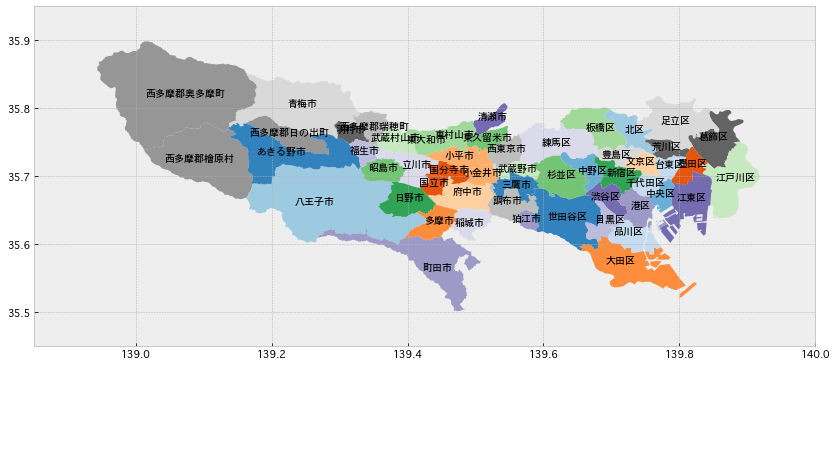

In [6]:
japan_ks.plot(column='city_name', cmap='tab20c', categorical=True, figsize=(14, 8))
plt.ylim([35.45,35.95])
plt.xlim([138.85,140])

for idx, row in japan_ks.iterrows():
    plt.annotate(
        s=row.city_name,
        xy=row.geom.representative_point().coords[0],
        horizontalalignment='center'
    )

plt.savefig("japan_ks.zoom.png", bbox_inches="tight", pad_inches=0.0)

ラベルが少し見にくいですがそれらしいような気がします。

土地利用別の可視化もしてみます。つまりjapan_alosを可視化します。下はカラーマップです。

In [7]:
alos_color_palette = {
    '00_未分類':     [0  /255 ,0  /255 ,0  /255 ],
    '01_水域':       [0  /255 ,0  /255 ,100/255 ],
    '02_都市':       [255/255 ,0  /255 ,0  /255 ],
    '03_水田':       [0  /255 ,128/255 ,255/255 ],
    '04_畑地':       [255/255 ,193/255 ,191/255 ],
    '05_草地':       [255/255 ,255/255 ,0  /255 ],
    '06_落葉広葉樹': [128/255 ,255/255 ,0  /255 ],
    '07_落葉針葉樹': [0  /255 ,255/255 ,128/255 ],
    '08_常緑広葉樹': [86 /255 ,172/255 ,0  /255 ],
    '09_常緑針葉樹': [130/255 ,172/255 ,117/255 ],
    '10_裸地':       [128/255 ,100/255 ,0  /255 ]
}

def alos_colors(alos_names):
    return mpl.colors.ListedColormap(
        [alos_color_palette[x] for x in alos_names],
        name="alos_colors",
        N=len(alos_names))

In [8]:
query = """
select
  japan_alos.geom as geom
  , japan_alos.city_name as city_name
  , alos_code_name.code as alos_code
  , to_char(alos_code_name.code, 'FM00') || '_' || alos_code_name.name as alos_name
from
  japan_alos
  left join alos_code_name on (japan_alos.alos_code = alos_code_name.code)
;
"""

with psycopg2.connect(**db_conn_dict) as conn:
    japan_alos = gpd.read_postgis(
        query, 
        conn,
        geom_col='geom',
        crs={'init': u'epsg:4326'}
    )

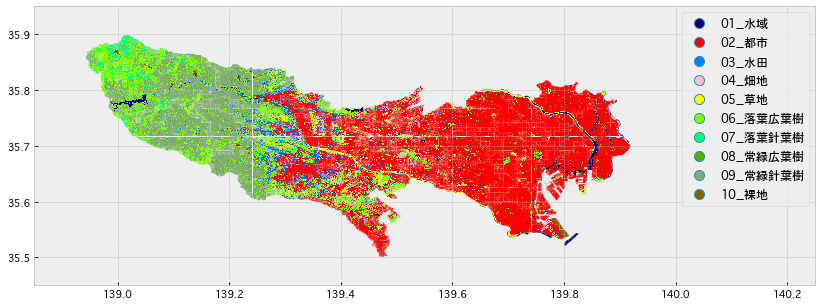

In [9]:
japan_alos.plot(
    column='alos_name',
    cmap=alos_colors(sorted(japan_alos.alos_name.unique())),
    categorical=True,
    legend=True,
    figsize=(14, 8)
)
plt.ylim([35.45,35.95])
plt.xlim([138.85,140.25])
plt.savefig("japan_alos.zoom.png", bbox_inches="tight", pad_inches=0.0)

出ました。

さて、市区町村ごとのalosの落葉広/落葉針/常緑広/常緑針葉樹の割合を算出します。

In [10]:
greenratio_query = """
select
    japan_alos.city_code
    , min(japan_alos.city_name) as city_name
    , sum(ST_Area(geography(japan_alos.geom))) / min(japan_ks.area) as green_ratio
from
    japan_alos
    left join alos_code_name on (japan_alos.alos_code = alos_code_name.code)
    left join japan_ks on (japan_alos.city_code = japan_ks.city_code)
where
    alos_code between 6 and 9
group by
    japan_alos.city_code
order by
    green_ratio desc, japan_alos.city_code
;"""

with psycopg2.connect(**db_conn_dict) as conn:
  greenratio = pd.io.sql.read_sql(greenratio_query, conn)

top10です。西多摩郡か島嶼です。西多摩郡檜原村というところがほとんど森です。

In [11]:
greenratio.head(n=10)

,city_code,city_name,green_ratio
0,13307,西多摩郡檜原村,0.992630
1,13308,西多摩郡奥多摩町,0.965666
2,13382,御蔵島村,0.915994
3,13361,大島町,0.836055
4,13362,利島村,0.832088
5,13305,西多摩郡日の出町,0.825971
6,13205,青梅市,0.763871
7,13364,神津島村,0.746610
8,13363,新島村,0.743949
9,13228,あきる野市,0.735391


可視化してみますが、やはりほとんど森です。

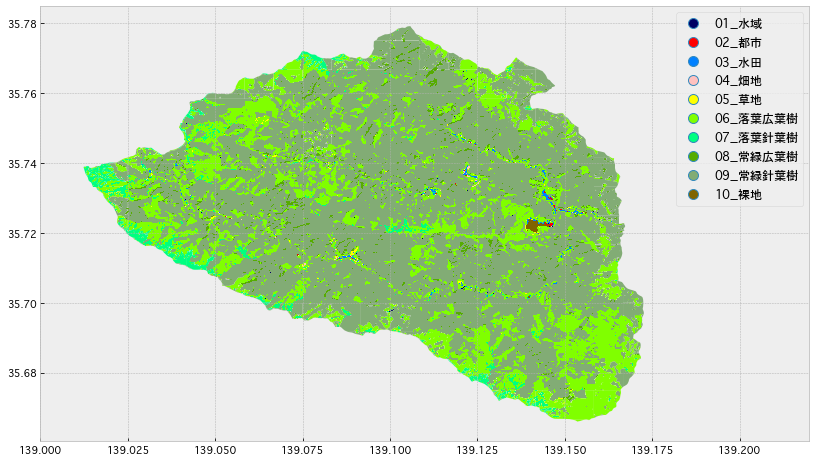

In [12]:
query = """
SELECT
    japan_alos.geom as geom
    , japan_alos.city_name as city_name
    , alos_code_name.code as alos_code
    , to_char(alos_code_name.code, 'FM00') || '_' || alos_code_name.name as alos_name
FROM
    japan_alos
    left join alos_code_name on (japan_alos.alos_code = alos_code_name.code)
where
    city_name = '西多摩郡檜原村'
;
"""

with psycopg2.connect(**db_conn_dict) as conn:
    hinoharamura = gpd.read_postgis(
        query, 
        conn,
        geom_col='geom',
        crs={'init': u'epsg:4326'}
    )

hinoharamura.plot(
    column='alos_name',
    cmap=alos_colors(sorted(hinoharamura.alos_name.unique())),
    categorical=True,
    legend=True,
    figsize=(14, 8)
)
plt.xlim([139,139.22])
# plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.savefig("hinoharamura.png", bbox_inches="tight", pad_inches=0.0)

東京23区のランキングです。千代田区が1位ですね。

In [13]:
greenratio[greenratio.city_code < 13200].reset_index(drop=True)

,city_code,city_name,green_ratio
0,13101,千代田区,0.110995
1,13113,渋谷区,0.092015
2,13103,港区,0.075061
3,13105,文京区,0.061869
4,13112,世田谷区,0.052596
5,13120,練馬区,0.046121
6,13115,杉並区,0.045913
7,13104,新宿区,0.037274
8,13109,品川区,0.035927
9,13110,目黒区,0.034893


千代田区も可視化してみました。緑を囲むお堀跡のような構造が見えます。これはつまり旧江戸城現皇居ですね。

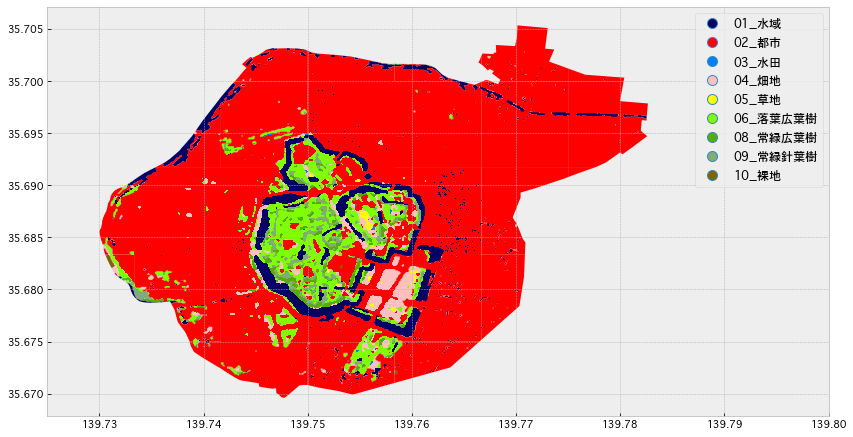

In [14]:
query = """
SELECT
    japan_alos.geom as geom
    , japan_alos.city_name as city_name
    , alos_code_name.code as alos_code
    , to_char(alos_code_name.code, 'FM00') || '_' || alos_code_name.name as alos_name
FROM
    japan_alos
    left join alos_code_name on (japan_alos.alos_code = alos_code_name.code)
where
    japan_alos.city_name = '千代田区'
;
"""

with psycopg2.connect(**db_conn_dict) as conn:
    chiyodaku = gpd.read_postgis(
        query, 
        conn,
        geom_col='geom',
        crs={'init': u'epsg:4326'}
    )

chiyodaku.plot(
    column='alos_name',
    cmap=alos_colors(sorted(chiyodaku.alos_name.unique())),
    categorical=True,
    legend=True,
    figsize=(14, 8)
)
plt.xlim([139.725,139.8])
# plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.savefig("chiyodaku.png", bbox_inches="tight", pad_inches=0.0)

皇居はずるいように思えたので、23区で2番めに緑が多い渋谷区です。こちらも緑色のオーバルが見られますが、これは代々木公園のようです。

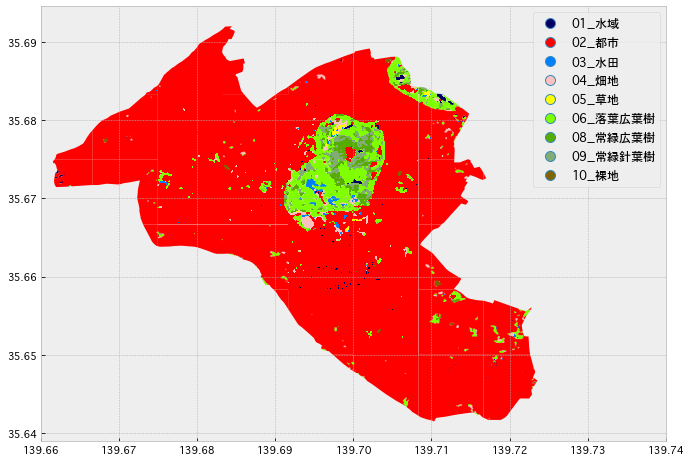

In [15]:
query = """
SELECT
    japan_alos.geom as geom
    , japan_alos.city_name as city_name
    , alos_code_name.code as alos_code
    , to_char(alos_code_name.code, 'FM00') || '_' || alos_code_name.name as alos_name
FROM
    japan_alos
    left join alos_code_name on (japan_alos.alos_code = alos_code_name.code)
where
    japan_alos.city_name = '渋谷区'
;
"""

with psycopg2.connect(**db_conn_dict) as conn:
    shibuyaku = gpd.read_postgis(
        query, 
        conn,
        geom_col='geom',
        crs={'init': u'epsg:4326'}
    )

shibuyaku.plot(
    column='alos_name',
    cmap=alos_colors(sorted(shibuyaku.alos_name.unique())),
    categorical=True,
    legend=True,
    figsize=(14, 8)
)
plt.xlim([139.66,139.74])
# plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.savefig("shibuyaku.png", bbox_inches="tight", pad_inches=0.0)

というわけで23区で一番緑が多いのは千代田区、皇居は入れないので除外すべきと思えば渋谷区となりました。

PostGISとかSQLは難しいので上の手続きをgeopandasだけでできると大変素敵ですね。